In [22]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.models import Sequential
from keras.layers import *
import os
import numpy as np
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

 99% 327M/331M [00:02<00:00, 128MB/s]
100% 331M/331M [00:03<00:00, 115MB/s]


In [4]:
import zipfile
zip=zipfile.ZipFile('/content/utkface-new.zip')
zip.extractall('/content')
zip.close()

In [5]:
folder_path='/content/utkface_aligned_cropped/UTKFace'

In [6]:
age = []
gender = []
ethnicity = []
img_path = []

for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)


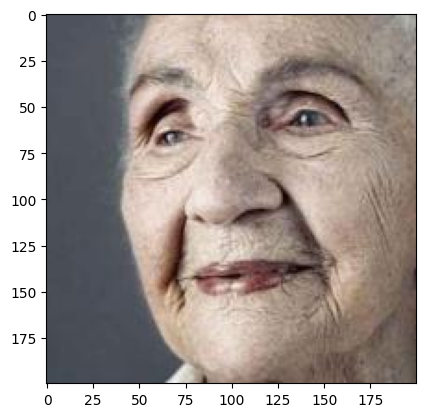

In [25]:

image = plt.imread("/content/UTKFace/100_1_0_20170112213001988.jpg.chip.jpg")
plt.imshow(image)

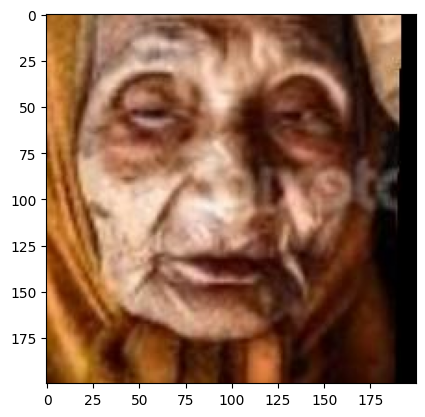

In [24]:
image = plt.imread("/content/UTKFace/100_1_2_20170112222336458.jpg.chip.jpg")
plt.imshow(image)

In [7]:
len(age)

23708

In [8]:
len(gender)

23708

In [9]:
df=pd.DataFrame({'age':age,'gender':gender,'img_path':img_path})

In [10]:
df.head()

,age,gender,img_path
0,16,0,16_0_0_20170110231520320.jpg.chip.jpg
1,50,0,50_0_1_20170117184611832.jpg.chip.jpg
2,2,1,2_1_1_20170109194159738.jpg.chip.jpg
3,26,1,26_1_1_20170116232330694.jpg.chip.jpg
4,17,1,17_1_1_20170113005047678.jpg.chip.jpg


In [11]:
train_df=df.sample(frac=1,random_state=0).iloc[:20000]
test_df=df.sample(frac=1,random_state=0).iloc[20000:]

In [12]:
train_df.shape,test_df.shape

((20000, 3), (3708, 3))

In [13]:
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=25,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255,rotation_range=25,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [14]:
train_generator = train_datagen.flow_from_dataframe(train_df, directory=folder_path,
                                                    x_col = 'img_path', y_col=['age','gender'],
                                                    target_size = (256, 256),
                                                    class_mode='multi_output')


test_generator = test_datagen.flow_from_dataframe(test_df, directory=folder_path,
                                                    x_col = 'img_path', y_col=['age','gender'],
                                                    target_size = (256, 256),
                                                    class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [15]:
from keras.layers import *
from keras.models import Model
from keras.applications.resnet50 import ResNet50

In [16]:
resnet=ResNet50(include_top=False,input_shape=(256,256,3))

94765736/94765736 [==============================] - 1s 0us/step


In [17]:
resnet = ResNet50(include_top=False, input_shape=(256, 256, 3))
resnet.trainable  = False

output = resnet.layers[-1].output
flatten = Flatten()(output)

dense1 = Dense(128, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(flatten)

dense3 = Dense(64, activation='relu')(dense1)
dense4 = Dense(64, activation='relu')(dense2)

output1 = Dense(1, activation='linear', name='age')(dense3)
output2 = Dense(1, activation='sigmoid', name='gender')(dense4)

model = Model(inputs=resnet.input, outputs=[output1, output2])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [19]:
model.compile(optimizer='adam', loss={'age':'mae', 'gender':'binary_crossentropy'},
              metrics={'age':'mae', 'gender':'accuracy'},
              loss_weights={'age':10, 'gender':90})

In [20]:
history = model.fit(train_generator, batch_size=32, epochs=5,
                    validation_data=test_generator)

Epoch 1/5
625/625 [==============================] - 440s 689ms/step - loss: 235.2688 - age_loss: 15.4190 - gender_loss: 0.9009 - age_mae: 15.4190 - gender_accuracy: 0.5210 - val_loss: 212.4245 - val_age_loss: 14.9633 - val_gender_loss: 0.6977 - val_age_mae: 14.9633 - val_gender_accuracy: 0.5178
Epoch 2/5
625/625 [==============================] - 422s 675ms/step - loss: 212.5201 - age_loss: 14.9820 - gender_loss: 0.6967 - age_mae: 14.9820 - gender_accuracy: 0.5410 - val_loss: 220.5764 - val_age_loss: 14.8279 - val_gender_loss: 0.8033 - val_age_mae: 14.8279 - val_gender_accuracy: 0.5165
Epoch 3/5
625/625 [==============================] - 423s 676ms/step - loss: 210.2408 - age_loss: 14.7945 - gender_loss: 0.6922 - age_mae: 14.7945 - gender_accuracy: 0.5342 - val_loss: 208.8881 - val_age_loss: 14.6504 - val_gender_loss: 0.6932 - val_age_mae: 14.6504 - val_gender_accuracy: 0.4844
Epoch 4/5
625/625 [==============================] - 416s 666ms/step - loss: 209.9214 - age_loss: 14.7625 - g

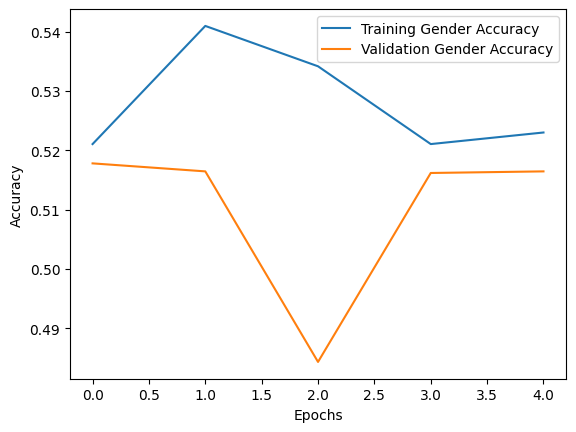

In [29]:
plt.plot(history.history['gender_accuracy'], label='Training Gender Accuracy')
plt.plot(history.history['val_gender_accuracy'], label='Validation Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
from keras.models import load_model

# Assuming 'model' is your trained model
# Save the model
model.save('your_model.h5')

# Load the model
loaded_model = load_model('your_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step


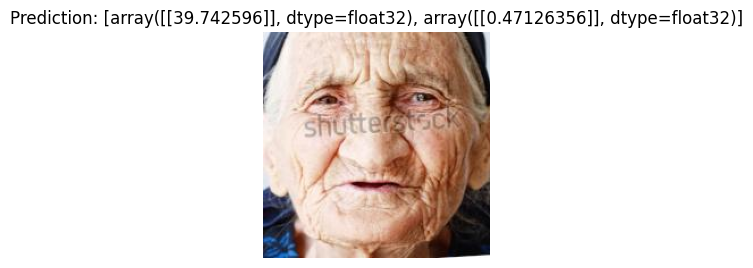

In [36]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Assuming you have a list of test image paths
test_image_paths = ['/content/crop_part1/100_1_0_20170110183726390.jpg.chip.jpg']

# Function to preprocess images for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))  # Specify your target size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Function to make predictions and visualize results
def visualize_predictions(model, image_paths):
    plt.figure(figsize=(10, 10))

    for i, img_path in enumerate(image_paths, 1):
        # Preprocess image
        img_array = preprocess_image(img_path)

        # Make prediction
        predictions = model.predict(img_array)

        # Visualize the original image
        plt.subplot(3, 3, i)
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.axis('off')

        # Display predicted results
        plt.title(f'Prediction: {predictions}')

    plt.show()

# Call the function with your trained model and list of test image paths
visualize_predictions(loaded_model, test_image_paths)